In [ ]:
## Taxonomy plots for centrifuge data by Ileana Galdamez (Callejas)
import os
import pandas as pd
import numpy as np

# Path to the folder containing TSV files
folder_path = '/Users/callejas/Library/CloudStorage/OneDrive-Personal/Belize 2022/taxonomy/centrifuge'  

# Dictionary to store DataFrames with filenames as keys
dfs = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.tsv'):  # Only process .tsv files
        file_path = os.path.join(folder_path, filename)
        # Read the TSV file
        df = pd.read_csv(file_path, sep='\t')
        # Store the DataFrame in the dictionary with filename as the key (without the extension)
        dfs[filename] = df

# DataFrame by filename
for file, df in dfs.items():
    print(f"Data from {file}:")
    print(df.head())  # Show the first few rows of each DataFrame


Data from A5-Snorkel_centrifuge_report.tsv:
                       name  taxID       taxRank  genomeSize  numReads  \
0                  Bacteria      2  superkingdom           0        89   
1              Azorhizobium      6         genus     5369772        40   
2  Azorhizobium caulinodans      7       species     5369772        36   
3       Buchnera aphidicola      9       species      602805       229   
4                Cellvibrio     10         genus     4576573        35   

   numUniqueReads  abundance  
0              68        0.0  
1               0        0.0  
2               0        0.0  
3              95        0.0  
4               0        0.0  
Data from A2-WCSR_centrifuge_report.tsv:
                       name  taxID       taxRank  genomeSize  numReads  \
0                  Bacteria      2  superkingdom           0       146   
1              Azorhizobium      6         genus     5369772        35   
2  Azorhizobium caulinodans      7       species     5369772  

In [ ]:
# Merge data for 'numReads' across all samples for comparison
comparison_df = dfs['A1-Fish_centrifuge_report.tsv'][['name', 'numReads']].rename(columns={'numReads': 'A1-Fish_numReads'})

for sample in ['A2-WCSR_centrifuge_report.tsv', 'A3-NA12_centrifuge_report.tsv', 
               'A4-BRB_centrifuge_report.tsv', 'A5-Snorkel_centrifuge_report.tsv', 
               'A6-NA11_centrifuge_report.tsv']:
    comparison_df = comparison_df.merge(
        dfs[sample][['name', 'numReads']].rename(columns={'numReads': f'{sample.split("_")[0]}_numReads'}),
        on='name',
        how='outer'
    )

# Specify the desired order of the columns
new_order = ['name', 'A2-WCSR_numReads','A4-BRB_numReads','A1-Fish_numReads','A3-NA12_numReads', 
             'A6-NA11_numReads','A5-Snorkel_numReads']

# Reorder the columns in the DataFrame
comparison_df = comparison_df[new_order]

# Print the reordered DataFrame
print(comparison_df)


                               name  A2-WCSR_numReads  A4-BRB_numReads  \
0                          Bacteria             146.0            214.0   
1                      Azorhizobium              35.0             44.0   
2          Azorhizobium caulinodans              94.0            117.0   
3               Buchnera aphidicola              84.0            149.0   
4                        Cellvibrio              23.0             31.0   
...                             ...               ...              ...   
15277        Escherichia virus SRT8               NaN              NaN   
15278        Pseudomonas virus KIL2               NaN              NaN   
15279        Pseudomonas virus KIL4               NaN              NaN   
15280  Streptomyces virus Mildred21               NaN              NaN   
15281                Vallitaleaceae               NaN              NaN   

       A1-Fish_numReads  A3-NA12_numReads  A6-NA11_numReads  \
0                 118.0             111.0       

In [3]:
# Loop through each TSV report and check for abundance values
for sample, df in dfs.items():
    print(f"Sample: {sample}")
    print(df[['taxRank', 'abundance']].groupby('taxRank').describe())  # Get statistics for abundance by taxonomic rank


Sample: A5-Snorkel_centrifuge_report.tsv
             abundance                                                  
                 count      mean       std  min  25%  50%  75%       max
taxRank                                                                 
class             76.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000
family           364.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000
genus           1228.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000
leaf            3772.0  0.000043  0.000948  0.0  0.0  0.0  0.0  0.043063
order            170.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000
phylum            13.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.000000
species         6481.0  0.000110  0.001778  0.0  0.0  0.0  0.0  0.083678
subspecies       127.0  0.000979  0.009462  0.0  0.0  0.0  0.0  0.105526
superkingdom       1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.000000
Sample: A2-WCSR_centrifuge_report.tsv
             abundance                       

In [ ]:
# Dictionary to store genus-level relative abundances based on 'numReads' or 'abundance' column
genus_data = {}

# Loop through each TSV report
for sample, df in dfs.items():
    # Filter for genus-level taxonomy
    genus_df = df[df['taxRank'] == 'genus']  # or 'species' for species-level plot
    
    # Filter out zero or missing numReads or abundance values
    genus_df = genus_df[genus_df['numReads'] > 0].dropna(subset=['numReads'])  # or use 'abundance' if plotting species-level

    if not genus_df.empty:
        # Calculate the total number of reads at the genus level
        total_genus_reads = genus_df['numReads'].sum()  # or 'abundance' for species-level plot
        
        # Calculate the relative abundance percentage for each genus
        genus_df['relative_abundance'] = (genus_df['numReads'] / total_genus_reads) * 100  # or 'abundance'
        
        # Store the relative abundance in the dictionary with genus names as index
        genus_data[sample] = genus_df[['name', 'relative_abundance']].set_index('name')

# Combine all the genus data into a single DataFrame
if genus_data:  # Only proceed if there's valid data
    combined_genus_df = pd.concat(genus_data, axis=1, sort=False).fillna(0)

    # Rename the columns to make them easier to read (sample names)
    combined_genus_df.columns = [col[0].replace('_centrifuge_report.tsv', '') for col in combined_genus_df.columns]

    # Specify the new column order
    new_order = ['A2-WCSR','A4-BRB','A1-Fish','A3-NA12','A6-NA11','A5-Snorkel']  # Adjust as necessary

    # Reorder the columns to match the new order
    combined_genus_df = combined_genus_df[new_order]

    # Rename the columns to the desired names
    combined_species_df.columns = ['WCSR', 'BRB', 'FISH', 'NA12', 'NA11', 'SNORKEL']

    # Filter out genera that have zero abundance across all samples
    filtered_genus_df = combined_genus_df.loc[(combined_genus_df.sum(axis=1) > 0)]
    
    # Calculate total relative abundance across all samples and filter the top 20 genera
    top_n = 20  # Set the number of top genera to display
    top_genera = filtered_genus_df.sum(axis=1).nlargest(top_n).index
    filtered_genus_df = filtered_genus_df.loc[top_genera]

    # Create the stacked bar plot
    filtered_genus_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

    # Set plot labels and title
    plt.ylabel('Relative Abundance (%)')
    plt.xlabel('Site')
    plt.xticks(rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Genus')  # Smaller legend with top taxa
    plt.tight_layout()
    plt.show()
else:
    print("No valid genus data found with non-zero numReads values.")


NameError: name 'combined_species_df' is not defined

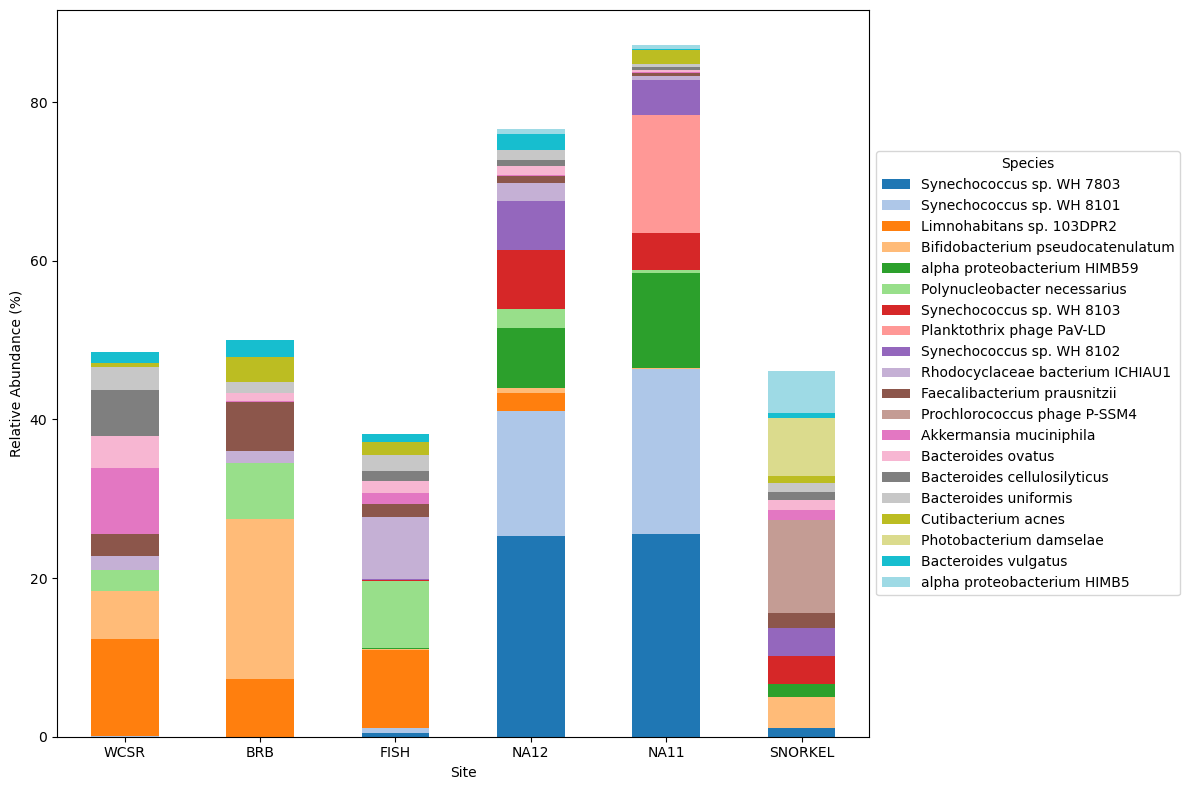

In [ ]:
# Dictionary to store species-level relative abundances based on 'abundance' column
species_data = {}

# Loop through each TSV report
for sample, df in dfs.items():
    # Filter for species-level taxonomy
    species_df = df[df['taxRank'] == 'species']
    
    # Filter out zero or missing abundance values
    species_df = species_df[species_df['abundance'] > 0].dropna(subset=['abundance'])

    if not species_df.empty:
        # Calculate the total abundance at the species level
        total_species_abundance = species_df['abundance'].sum()
        
        # Calculate the relative abundance percentage for each species
        species_df['relative_abundance'] = (species_df['abundance'] / total_species_abundance) * 100
        
        # Store the relative abundance in the dictionary with species names as index
        species_data[sample] = species_df[['name', 'relative_abundance']].set_index('name')

# Combine all the species data into a single DataFrame
if species_data:  # Only proceed if there's valid data
    combined_species_df = pd.concat(species_data, axis=1, sort=False).fillna(0)

    # Rename the columns to make them easier to read (sample names)
    combined_species_df.columns = [col[0].replace('_centrifuge_report.tsv', '') for col in combined_species_df.columns]

    # Specify the new column order
    new_order = ['A2-WCSR', 'A4-BRB', 'A1-Fish', 'A3-NA12', 'A6-NA11', 'A5-Snorkel']  # Adjust as necessary

    # Reorder the columns to match the new order
    combined_species_df = combined_species_df[new_order]

    # Rename the columns to the desired names
    combined_species_df.columns = ['WCSR', 'BRB', 'FISH', 'NA12', 'NA11', 'SNORKEL']

    # Filter out species that have zero abundance across all samples
    filtered_species_df = combined_species_df.loc[(combined_species_df.sum(axis=1) > 0)]
    
    # Calculate total relative abundance across all samples and filter the top 20 species
    top_n = 20  # Set the number of top species to display
    top_species = filtered_species_df.sum(axis=1).nlargest(top_n).index
    filtered_species_df = filtered_species_df.loc[top_species]

    # Create the stacked bar plot
    filtered_species_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

    # Set plot labels and title
    plt.ylabel('Relative Abundance (%)')
    plt.xlabel('Site')
    plt.xticks(rotation=0)  # Set rotation to 0 for horizontal x-axis labels
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Species')  # Smaller legend with top taxa
    plt.tight_layout()
    plt.show()
else:
    print("No valid species data found with non-zero abundance values.")


In [ ]:
# Dictionary to store species-level relative abundances based on 'abundance' column
species_data = {}

# Loop through each TSV report
for sample, df in dfs.items():
    # Filter for species-level taxonomy
    species_df = df[df['taxRank'] == 'species']
    
    # Filter out zero or missing abundance values
    species_df = species_df[species_df['abundance'] > 0].dropna(subset=['abundance'])

    if not species_df.empty:
        # Calculate the total abundance at the species level
        total_species_abundance = species_df['abundance'].sum()
        
        # Calculate the relative abundance percentage for each species
        species_df['relative_abundance'] = (species_df['abundance'] / total_species_abundance) * 100
        
        # Store the relative abundance in the dictionary with species names as index
        species_data[sample] = species_df[['name', 'relative_abundance']].set_index('name')

# Combine all the species data into a single DataFrame
if species_data:  # Only proceed if there's valid data
    combined_species_df = pd.concat(species_data, axis=1, sort=False).fillna(0)

    # Rename the columns to make them easier to read (sample names)
    combined_species_df.columns = [col[0].replace('_centrifuge_report.tsv', '') for col in combined_species_df.columns]

    # Specify the new column order
    new_order = ['A2-WCSR', 'A4-BRB', 'A1-Fish', 'A3-NA12', 'A6-NA11', 'A5-Snorkel']  # Adjust as necessary

    # Reorder the columns to match the new order
    combined_species_df = combined_species_df[new_order]

    # Rename the columns to the desired names
    combined_species_df.columns = ['WCSR', 'BRB', 'FISH', 'NA12', 'NA11', 'SNORKEL']

    # Dictionary to store the top 20 species for each site
    top_species_per_site = {}

    # Loop through each site and get the top 20 species based on relative abundance
    for site in combined_species_df.columns:
        top_20_species = combined_species_df[site].nlargest(20)  # Get top 20 species for this site
        top_species_per_site[site] = top_20_species.index  # Store the species names for this site

        # Print the top 20 species for each site
        print(f"Top 20 species for {site}:")
        print(top_20_species)

else:
    print("No valid species data found with non-zero abundance values.")

    # Create a set to store the unique species from the top 20 lists
unique_species_set = set()

# Loop through each site and add the top 20 species to the set
for site in combined_species_df.columns:
    top_20_species = combined_species_df[site].nlargest(20).index  # Get top 20 species for this site
    unique_species_set.update(top_20_species)  # Add species to the set (automatically removes duplicates)

# Calculate the number of unique species
num_unique_species = len(unique_species_set)

# Print the result
print(f"Number of unique species represented in the top 20 across all sites: {num_unique_species}")

from collections import defaultdict

# Dictionary to track which samples each species was found in
species_samples = defaultdict(list)

# Loop through each site and find the top 20 species
for site in combined_species_df.columns:
    top_20_species = combined_species_df[site].nlargest(20).index  # Get top 20 species for this site
    for species in top_20_species:
        species_samples[species].append(site)  # Add the site to the species list

# Now count how many samples each species was found in
species_counter = {species: len(sites) for species, sites in species_samples.items()}

# Sort the species by count
most_common_species = sorted(species_counter.items(), key=lambda x: x[1], reverse=True)

# Print the result
print("Most common species across sites (species, count, samples):")
for species, count in most_common_species:
    samples = species_samples[species]
    print(f"{species}: {count} occurrences, found in samples: {', '.join(samples)}")



Top 20 species for WCSR:
name
Limnohabitans sp. 103DPR2                 12.274274
Akkermansia muciniphila                    8.234305
Bifidobacterium pseudocatenulatum          6.088529
Bacteroides cellulosilyticus               5.915681
Bacteroides ovatus                         4.031177
Bacteroides uniformis                      2.837461
Faecalibacterium prausnitzii               2.742694
Polynucleobacter necessarius               2.630652
Candidatus Methylopumilus planktonicus     2.405509
Candidatus Planktophila sulfonica          2.380553
Aeromonas veronii                          1.933360
Rhodocyclaceae bacterium ICHIAU1           1.788479
Candidatus Nanopelagicus limnes            1.557462
Actinobacteria bacterium IMCC25003         1.446076
Bacteroides caccae                         1.360649
Bacteroides vulgatus                       1.344163
Streptococcus thermophilus                 1.271458
Cellvibrio sp. KY-GH-1                     1.266571
Bifidobacterium bifidum           

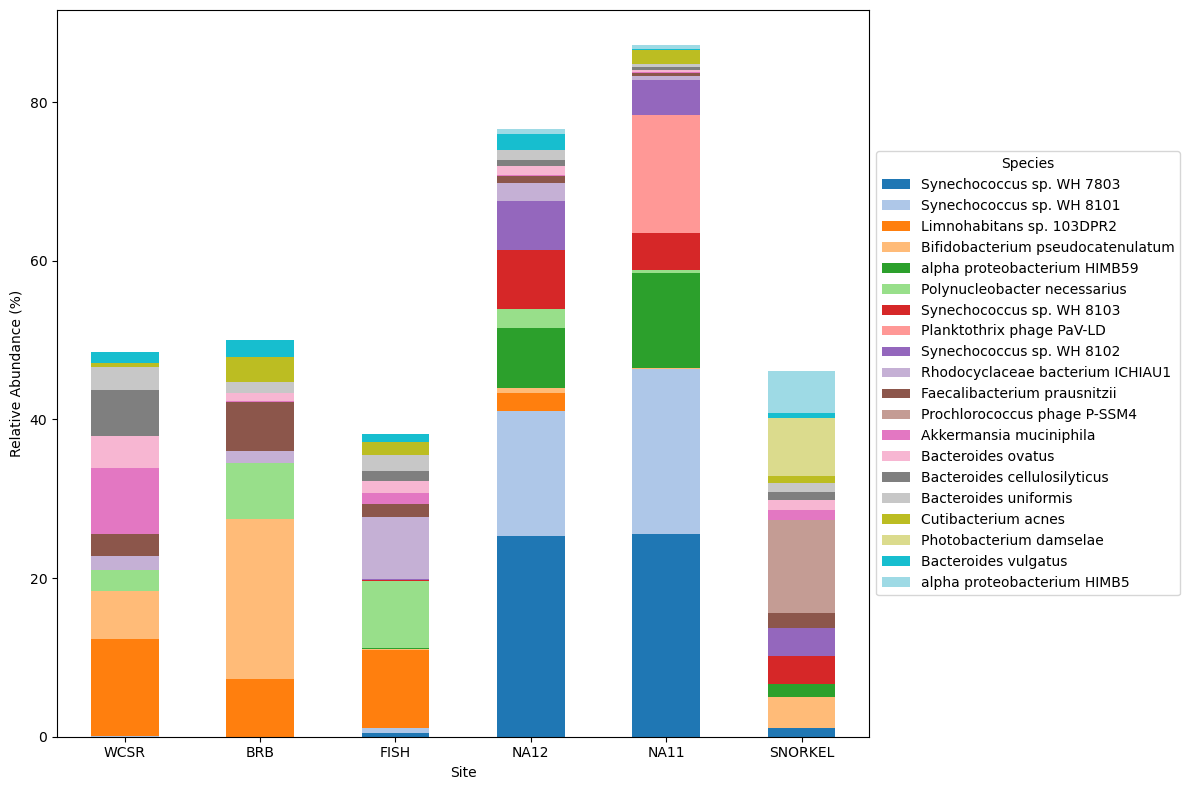

In [ ]:
import matplotlib.pyplot as plt

# Dictionary to store species-level relative abundances based on 'abundance' column
species_data = {}

# Loop through each TSV report
for sample, df in dfs.items():
    # Filter for species-level taxonomy
    species_df = df[df['taxRank'] == 'species']
    
    # Filter out zero or missing abundance values
    species_df = species_df[species_df['abundance'] > 0].dropna(subset=['abundance'])

    if not species_df.empty:
        # Calculate the total abundance at the species level
        total_species_abundance = species_df['abundance'].sum()
        
        # Calculate the relative abundance percentage for each species
        species_df['relative_abundance'] = (species_df['abundance'] / total_species_abundance) * 100
        
        # Store the relative abundance in the dictionary with species names as index
        species_data[sample] = species_df[['name', 'relative_abundance']].set_index('name')

# Combine all the species data into a single DataFrame
if species_data:  # Only proceed if there's valid data
    combined_species_df = pd.concat(species_data, axis=1, sort=False).fillna(0)

    # Rename the columns to make them easier to read (sample names)
    combined_species_df.columns = [col[0].replace('_centrifuge_report.tsv', '') for col in combined_species_df.columns]

    # Specify the new column order
    new_order = ['A2-WCSR', 'A4-BRB', 'A1-Fish', 'A3-NA12', 'A6-NA11', 'A5-Snorkel']  # Adjust as necessary

    # Reorder the columns to match the new order
    combined_species_df = combined_species_df[new_order]

    # Rename the columns to the desired names
    combined_species_df.columns = ['WCSR', 'BRB', 'FISH', 'NA12', 'NA11', 'SNORKEL']

    # Filter out species that have zero abundance across all samples
    filtered_species_df = combined_species_df.loc[(combined_species_df.sum(axis=1) > 0)]
    
    # Calculate total relative abundance across all samples and filter the top 20 species
    top_n = 20  # Set the number of top species to display
    top_species = filtered_species_df.sum(axis=1).nlargest(top_n).index
    filtered_species_df = filtered_species_df.loc[top_species]

    # Create the stacked bar plot
    ax = filtered_species_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')

    # Set plot labels and title
    plt.ylabel('Relative Abundance (%)')
    plt.xlabel('Site')
    plt.xticks(rotation=0)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Species')  # Smaller legend with top taxa
    plt.tight_layout()
    plt.show()
else:
    print("No valid species data found with non-zero abundance values.")
